In [1]:
# Xiaopu Peng

In [2]:
# check whats in the root folder
from subprocess import check_output
print(check_output(['ls', './']).decode('utf8'))

ExpCompareAll.ipynb
ExpCompareBasic.ipynb
ExpFixWorkload.ipynb
ExpUPScompare.ipynb
UPScompare.eps
__pycache__
compareAll.eps
comparision
fixWorkloadCompare.eps
fixWrokloadCompare.eps



# Imports

In [3]:
import sys
sys.path.insert(0, '/Users/xiaopupeng/Dropbox/WorkSpace/Redux/')
import random
import Methods as mt
import numpy as np
import pandas as pd
# %matplotlib inline
%matplotlib notebook
# %matplotlib widget
import matplotlib.pyplot as plt
# import Redux as rd
plt.style.use('ggplot')
# plt.style.use('default')

## Initialize

In [4]:
# ############CONSTANT############
# ratio of stats count when start the arithmetic average estimate
scaleRatio = 0.01
# ability of ups devise, could be more sophisticated in future (kWh)
upsCapability = 500
# the workload processing capability of data center (by kWh energy need)
workloadCapability = 2500
# ups and renewable energy price ($)
upsPrice = 0.02
solarPrice = 0.09
windPrice = 0.15

# ##############INITIALIZE###################
# initialized ups original storage by ratio
initUpsStorage = upsCapability * 0.5
# save the amount of deferred workload to a cache
initWorkloadPool = 0
# the initialized threshold of grid price ($)
initGridpriceThreshold = 1.0
# initialized high and low ratio of current workload for workload shaving
initCurWorkloadRatio = 0.2
# initialized stable renewable supply level
initStableRenSupply = 500
# initialize statistic recorders  and
gridpriceStat = []
workloadStat = []
renSupplyStat = []
fluRenSupplyStat = []  # renewable supply fluctuation
stableRenSupplyStat = []  # stable renewable supply

# initialize all statistical records
reduxStat = []
noReduxStat = []
costGapStat = []
specialCase = []
reduxAccu = []
noReduxAccu = []

reupsStat = []
reupsAccu = []
greenswitchStat = []
greenswitchAccu = []
#######################################

## Dataset

In [5]:
dataDir = '/Users/xiaopupeng/Dropbox/WorkSpace/Redux/data/'
workloadData, gridpriceData, solarSupplyData, windSupplyData, renSupplyData = mt.loadData(dataDir)

## Preprocess (need solar&wind model)

In [6]:
gridmean = gridpriceData.mean()

# topLevel

In [14]:
gridpriceThreshold = initGridpriceThreshold
workloadPool = initWorkloadPool
curWorkloadRatio = initCurWorkloadRatio
stableRenSupply = initStableRenSupply
upsStorage = initUpsStorage

curTime = 0
finTime = 2568  # number of timeslots
WINDOW = finTime * scaleRatio

while curTime < finTime:
    # print('current time:', curTime)

    # derive renewable price by weighted average from wind and solar price
    renPrice = (windSupplyData[curTime] * windPrice + solarSupplyData[curTime] * solarPrice) / (windSupplyData[curTime] + solarSupplyData[curTime])

    # get the current grid price, append to grid price statistic and decide whether it is high or low
    
    #############
#     gridPrice = gridpriceData[curTime]
    gridPrice = gridmean*1.1
    ##############
    
    gridpriceStat.append(gridPrice)
    ###############
    # call method to estimate grid price state
#     gridpriceThreshold, gridpriceState = mt.estimateGridPriceState(gridpriceStat, gridpriceThreshold, finTime, gridPrice, scaleRatio)
    gridpriceState = random.choice(['high', 'low'])
    ###############

    # get the current workload and append to workload statistic, use real trace data for the next step
    curWorkload = workloadData[curTime]

    # first, do workload shaving to avoid over-capability load
    curWorkload, workloadPool = mt.workloadShaving(curWorkload, workloadCapability, workloadPool)
    workloadStat.append(curWorkload)
    
    # get the current workload and append to workload statistic
    renSupply = renSupplyData[curTime]
    renSupplyStat.append(renSupply)
    
    # calculate greenswitchCost (noRedux, but with renewable energy)
#     greenswitchCost = mt.calculateGreenswitchCost(renSupply, curWorkload, workloadPool, gridPrice, renPrice)
#     greenswitchStat.append(greenswitchCost)
#     greenswitchAccu.append(sum(greenswitchStat))

    # then smoothing the current workload by exponential windowed avarage
    curWorkload, workloadPool = mt.workloadSmoothing(curWorkload, workloadPool, workloadStat, WINDOW)

    # update the high and low ratio of workload according to smoothed workload, will approach to 0.8 and 0.2 as when more workload recorded
    curWorkloadHighRatio, curWorkloadLowRatio = mt.updateWorkloadRatio(workloadStat, finTime, curWorkloadRatio, scaleRatio)

    workloadState = mt.updateWorkloadState(curWorkload, curWorkloadHighRatio, curWorkloadLowRatio, workloadCapability)

    # decide utilization level of ups for current time spot
    upsAbility = mt.updateUpsUtilityLevel(workloadState, upsCapability)

    ############################################
    # define renewable state
    # we need to figure out how to define fluctuate and tell why we still use grid as
    # much as possible when grid price is low(by always set a low price), otherwise we lost our motivation
    renState = mt.defineRenState(renSupply, renSupplyStat, renSupplyData, WINDOW)
    ##############################################

    # smoothing supply and demand if necessary
    if renState == 'fluctuate':
        # record the fluctuating renewable supply
        fluRenSupplyStat.append(renSupply)
        # update the stable renewable supply level by historical fluctuate renewable supply stat
        stableRenSupply = mt.getStableRenSupply(fluRenSupplyStat, WINDOW)
        # conduct renewable energy supply
        renSupply, upsStorage, stableGridSupply, upsSupplyFlu = mt.renSupplySmooth(gridpriceState, gridPrice, renSupply, renPrice, stableRenSupply, upsAbility, upsStorage)
    else:
        upsSupplyFlu = 0
        stableGridSupply = 0

    # dynamically decide overpeak workload level
    workloadOVR = mt.updateOverpeak(gridpriceState, curWorkloadHighRatio, curWorkloadLowRatio, workloadCapability, workloadPool, renState, renSupply, stableRenSupply, gridPrice, renPrice)

    # status['workloadState'] == 'overPeak'
    curWorkload, workloadPool = mt.workloadShaving(curWorkload, workloadOVR, workloadPool)

    # decide whether discharge or recharge UPS
    upsSupply, upsStorage = mt.updateUpsSupply(gridpriceState, curWorkload, workloadOVR, renState, upsStorage, upsCapability, upsSupplyFlu)

    # waste renSupply if it is higher than curWorkload
    if renSupply + upsSupply > curWorkload:
        renSupply = curWorkload - upsSupply

    # find gridSupply by supply constrain
    gridSupply = curWorkload - renSupply - upsSupply + stableGridSupply

    # calculate redux cost
    reduxCost = gridPrice * gridSupply + renPrice * renSupply + upsPrice * abs(upsSupply)

    #####################
#     reduxStat.append(reduxCost)
#     reduxAccu.append(sum(reduxStat))
    
    reupsStat.append(reduxCost)
    reupsAccu.append(sum(reupsStat))
    #####################

    curTime += 1

print('Finished')

Finished


In [25]:
print(reupsAccu)

[656.1530276378456, 2373.9161099562016, 2811.264775141455, 3484.953512308439, 4087.6394078602516, 5944.382019639231, 6778.142379193819, 7388.328283163839, 8140.254760058135, 8880.93543361073, 9627.073478067927, 10502.697865669257, 11360.726964505948, 12228.819922810779, 12921.52671050905, 14210.57313582515, 15038.860512772257, 15868.215744901552, 17452.487547912235, 18441.668593464237, 19115.71538116251, 20321.332791090077, 21299.69747077063, 22102.808165227074, 22659.720583325467, 23916.758713437655, 24951.91577236248, 25739.0959653621, 26743.95093067829, 27655.564435516128, 28379.88750173758, 29061.46428943585, 30161.080690841074, 31067.106630049646, 31661.060109410966, 32157.359354130553, 32864.67614182882, 33815.13505256943, 34632.1244844639, 35483.96765268584, 36301.62004862207, 36963.54423165812, 37763.05888327903, 38612.45918046433, 38842.58741179438, 40141.37750636735, 40953.47597752537, 41610.00505745272, 42265.33413738007, 42890.34150298079, 43436.04571343998, 44090.499197162

In [26]:
print(reduxAccu)

[787.3612635756712, 1797.2676756268006, 2667.1269100233653, 2791.6446352631156, 3675.694715066079, 3864.683200655055, 3874.631215641409, 4348.153549798099, 4474.720305623488, 5167.050706155363, 6002.9463649870495, 6871.758450600592, 7556.760967451886, 8662.177570048007, 9902.584970038477, 11182.484968928133, 12127.29061245046, 12402.421648489088, 14358.413825703281, 15171.479399051277, 16460.839059659604, 17046.19315656407, 17567.15020727524, 18163.297915321607, 18943.188832457097, 19564.009633859132, 20150.447316094604, 20632.44421322422, 21163.27309195816, 21673.23097496108, 22234.18052647515, 23287.596315169954, 23940.246627272045, 24437.460391974375, 25017.29920936393, 25547.726017921806, 26407.992531040887, 27223.52386285647, 28136.493241131277, 29128.220743607693, 30086.24282769653, 30818.025203876117, 31679.092207192196, 32336.179412874455, 32894.12922638417, 34048.368201175464, 34722.69280525124, 35515.41731798556, 36039.05422094443, 36446.59791600625, 36972.822525113996, 37416

In [27]:
print(greenswitchAccu)

[919.5362635756711, 1929.4426756268006, 2544.5519100233655, 2893.969635263116, 3530.8197150660794, 3950.4582006550554, 3960.4062156414097, 4433.9285497981, 4560.495305623488, 5252.825706155363, 6088.72136498705, 6551.834394072726, 7319.965967011571, 8510.580280451064, 9750.987680441534, 11113.811600899819, 12058.617244422147, 12442.12599898693, 14577.978736099527, 15292.159351639457, 16581.519012247783, 17269.282589193655, 17790.239639904827, 18430.317347951193, 19276.692519686745, 19661.390154726952, 20247.827836962424, 20649.27153256083, 21121.89460600788, 21491.758980057304, 22098.504910401458, 23151.920699096263, 23688.091116037867, 24600.315753792223, 25293.597951709133, 26248.81564231873, 27287.678606646186, 28374.586050186903, 29163.378057823684, 30029.505800558247, 30299.89534507945, 30836.25352792566, 31249.248631078237, 32095.280705694175, 33087.00876439453, 33900.74773918583, 34264.144195198205, 35056.868707932525, 35413.242784471855, 35475.46622918279, 36052.01191186842, 36

In [28]:
monthlyStatRedux = []
monthlyStatRedux.append(reduxAccu[855].round(2))
monthlyStatRedux.append(reduxAccu[1711].round(2))
monthlyStatRedux.append(reduxAccu[2567].round(2))

monthlyStatReUPS = []
monthlyStatReUPS.append(reupsAccu[855].round(2))
monthlyStatReUPS.append(reupsAccu[1711].round(2))
monthlyStatReUPS.append(reupsAccu[2567].round(2))

monthlyStatGreenswitch = []
monthlyStatGreenswitch.append(greenswitchAccu[855].round(2))
monthlyStatGreenswitch.append(greenswitchAccu[1711].round(2))
monthlyStatGreenswitch.append(greenswitchAccu[2567].round(2))

In [29]:
print(monthlyStatRedux)
print(monthlyStatReUPS)
print(monthlyStatGreenswitch)

[604821.44, 1330663.89, 1972270.34]
[765215.58, 1524093.47, 2321717.9]
[667445.95, 1555229.6, 2278287.49]


In [30]:
for i in range(3):
    print(monthlyStatGreenswitch[i] / monthlyStatRedux[i] - 1)

0.103542146257249
0.1687621582637222
0.15515983980167758


In [31]:
for i in range(3):
    print(monthlyStatReUPS[i] / monthlyStatRedux[i] - 1)

0.26519255005245856
0.1453632141471879
0.17718035550846434


<IPython.core.display.Javascript object>


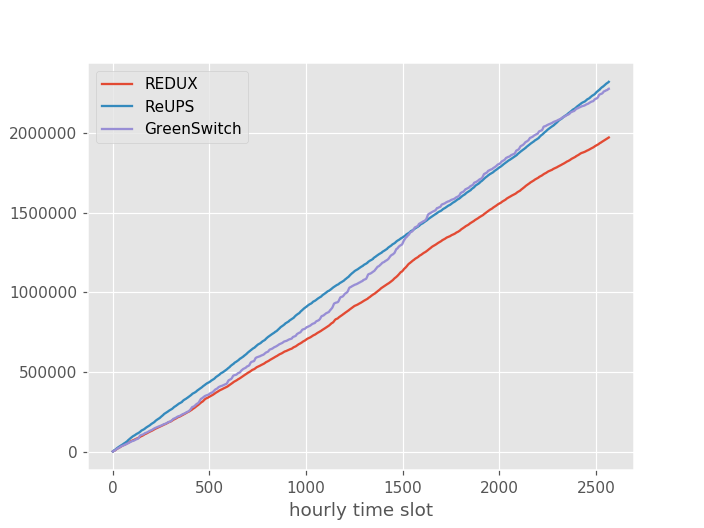

In [44]:
plt.plot(reduxAccu, label='REDUX')
plt.plot(reupsAccu, label='ReUPS')
plt.plot(greenswitchAccu, label='GreenSwitch')
plt.ylabel('dollars')
plt.xlabel('hourly time slot')
# plt.title('Accumulative total cost compare of ReUPS, GreenSwitch and Redux')
plt.legend(loc='best')
plt.show()

In [45]:
plt.savefig('compareAll.png')
plt.close()

In [ ]:
# How to plot 3 graphs together
# for i, col, in enumerate(features.columns):
#     plt.subplot(1, 3, i+1)
#     x = data[col]
#     y = prices
#     plt.plot(x,y,'o')
#     plt.plot(np.unique(x), npplot1d(np.plotfit(x,y,1))(np.unique(x)))
#     plt.title(col)
#     plt.xlabel(col)
#     plt.ylable('prices')